(probprog_pymc_nb)=

In [1]:
%matplotlib inline

In [2]:
import logging
from warnings import filterwarnings

In [3]:
from aesara import pprint
from matplotlib import pyplot as plt, ticker
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [4]:
filterwarnings(
    'ignore', category=UserWarning, module='pymc',
    message="Unable to validate shapes: Cannot sample from flat variable",
)
filterwarnings('ignore', category=RuntimeWarning, module='pymc')

In [5]:
def filter_metropolis(record):
    return not (record.msg.startswith(">Metropolis") or record.msg == "CompoundStep")

logging.getLogger('pymc').addFilter(filter_metropolis)

In [6]:
# configure pyplot for readability when rendered as a slideshow and projected
FIG_WIDTH, FIG_HEIGHT = 8, 6
plt.rc('figure', figsize=(FIG_WIDTH, FIG_HEIGHT))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

dollar_formatter = ticker.StrMethodFormatter("${x:,.0f}")
pct_formatter = ticker.StrMethodFormatter("{x:.1%}")

sns.set(color_codes=True)

<img src="https://secure-content.meetupstatic.com/images/classic-events/500978458/1352x760.webp">

## About this talk

## Agenda

* Probabilistic programming from two perspectives
    * Philosophical: storytelling with data
    * Mathematical: Monte Carlo methods
* Probabilistic programming with PyMC
    * The Monty Hall problem
    * Robust regression
* Hamiltonian Monte Carlo
    * Aesara
* Lego? example
* Next Steps

All the code that is shown in this webinar can be executed from its website. Therefore you have two ways to follow along:
 
- Click on the run code button and execute the code straight from this page

::::{div} sd-d-flex-row sd-align-major-center
:::{thebe-button}
:::
::::
- Clone the GitHub repo: [pymc-devs/pymc-data-umbrella](https://github.com/pymc-devs/pymc-data-umbrella) and follow along locally using Jupyter

## Probabilistic programming from two perspectives

### Philosophical

#### (Classical) Data science —— inference enables story telling

<center>
<figure>
    <img src="https://www.edwardtufte.com/tufte/graphics/minard_lg.gif">
    <caption>Image credit: <a href="https://www.edwardtufte.com/">Edward Tufte</a></caption>
</figure>
</center>

#### Probabilistic programming —— story telling enables inference

<center>
<figure>
    <img src="https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/probablistic-programming-lg-a4b8991929205945dbc850ce4dafc845.png">
    <caption>Image credit: <a href="https://www.oreilly.com/content/probabilistic-programming/">O'Reilly</a></caption>
</figure>
</center>

#### Bayesian inference —— quantifying uncertainty

<center>
<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg">
    <caption>Image credit: <a href="https://commons.wikimedia.org/wiki/File:Bayes%27_Theorem_MMB_01.jpg">Wikipedia</a></caption>
</figure>
</center>

### Mathematical

#### Monte Carlo methods

In [7]:
SEED = 123456789 # for reproducibility
rng = np.random.default_rng(SEED)

In [8]:
N = 5_000
x, y = rng.uniform(-1, 1, size=(2, N))

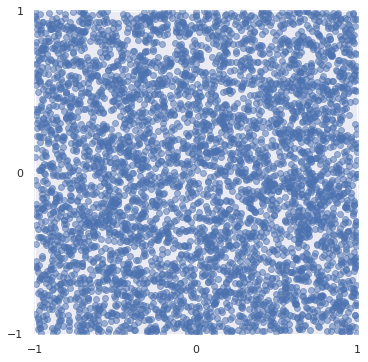

In [9]:
fig, ax = plt.subplots(subplot_kw={"aspect": "equal"})

ax.scatter(x, y, alpha=0.5);

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

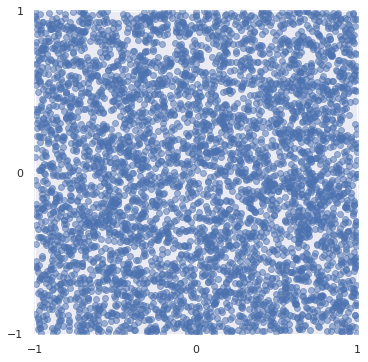

In [10]:
fig

In [11]:
in_circle = x**2 + y**2 < 1

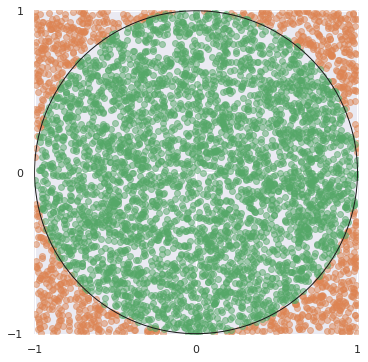

In [12]:
fig, ax = plt.subplots(subplot_kw={"aspect": "equal"})

ax.scatter(x[~in_circle], y[~in_circle],
           c='C1', alpha=0.5);
ax.scatter(x[in_circle], y[in_circle],
           c='C2', alpha=0.5);

ax.add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor='k'));

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

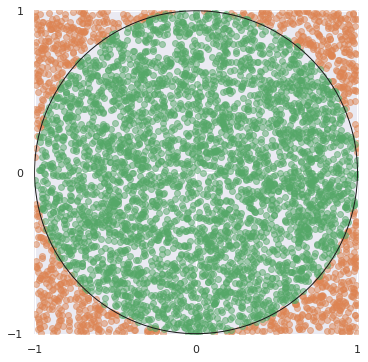

In [13]:
fig

In [14]:
4 * in_circle.sum() / N

3.1488

#### Monte Carlo methods —— approximating (intractible) integrals

$$\pi = 4 \int_0^1 \sqrt{1 - x^2}\ dx$$

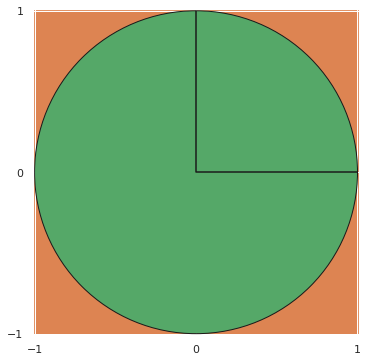

In [15]:
fig, ax = plt.subplots(subplot_kw={"aspect": "equal"})

ax.set_facecolor('C1');
ax.add_artist(plt.Circle((0, 0), 1, facecolor='C2', edgecolor='k'));
ax.plot([0, 0, 1], [1, 0, 0], c='k');

ax.set_xticks([-1, 0, 1]);
ax.set_xlim(-1.01, 1.01);

ax.set_yticks([-1, 0, 1]);
ax.set_ylim(-1.01, 1.01);

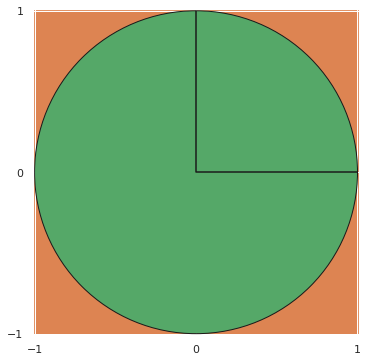

In [16]:
fig

#### Bayes' Theorem —— (often) intractible integrals

$$f(\theta\ |\ \mathcal{D}) = \frac{f(\mathcal{D}\ |\ \theta) \cdot f(\theta)}{\color{red}{\int f(\mathcal{D}\ |\ \theta) \cdot f(\theta)\ d\theta}}$$

Forcing <span style="color:red;">this term</span> to be analytically tractible drastically limits the richness of the models we can consider.

## Probabilistic Programming with PyMC

### The Monty Hall Problem

<center>
<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png">
    <caption>Image credit: <a href="https://en.wikipedia.org/wiki/Monty_Hall_problem">Wikipedia</a></caption>
</figure>
</center>

#### Mathematical solution

$$
\begin{align*}
P(\text{Behind 1}\ |\ \text{Opened 3})
    & = \frac{P(\text{Opened 3}\ |\ \text{Behind 1}) \cdot P(\text{Behind 1})}{P(\text{Opened 3})} \\
P(\text{Opened 3})
    & = P(\text{Opened 3}\ |\ \text{Behind 1}) \cdot P(\text{Behind 1}) \\
    & \ \ \ \ + P(\text{Opened 3}\ |\ \text{Behind 2}) \cdot P(\text{Behind 2}) \\
    & \ \ \ \ + P(\text{Opened 3}\ |\ \text{Behind 3}) \cdot P(\text{Behind 3}) \\
    & = \frac{1}{2} \cdot \frac{1}{3} + 1 \cdot \frac{1}{3} + 0 \cdot \frac{1}{3}
      = \frac{1}{2} \\
P(\text{Behind 1}\ |\ \text{Opened 3})
    & = \frac{\frac{1}{2} \cdot \frac{1}{3}}{\frac{1}{2}}
      = \frac{1}{3}
\end{align*}
$$

#### PyMC solution

Initially, we have no information about which door the prize is behind.

**TODO: update Docker image to get rid of warning**

In [17]:
import pymc as pm

with pm.Model() as monty_model:
    prize = pm.DiscreteUniform("prize", 0, 2, initval=0)

If we choose the first door:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Prize behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 3</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In [18]:
from aesara import tensor as aet

In [19]:
p_open = aet.switch(
    aet.eq(prize, 0),
    np.array([0, 0.5, 0.5]), # it is behind the first door
    aet.switch(
        aet.eq(prize, 1),
        np.array([0, 0, 1]), # it is behind the second door
        np.array([0, 1, 0])  # it is behind the third door
    )
)

Monty opened the third door, revealing a goat.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png"></center>

In [20]:
with monty_model:
    opened = pm.Categorical("opened", p_open, observed=2)

In [21]:
with monty_model:
    monty_trace = pm.sample(10_000)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [prize]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [22]:
print(monty_trace.posterior["prize"].head())

<xarray.DataArray 'prize' (chain: 2, draw: 5)>
array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4


In [23]:
print((monty_trace.posterior["prize"] == 0).mean())

<xarray.DataArray 'prize' ()>
array(0.3215)


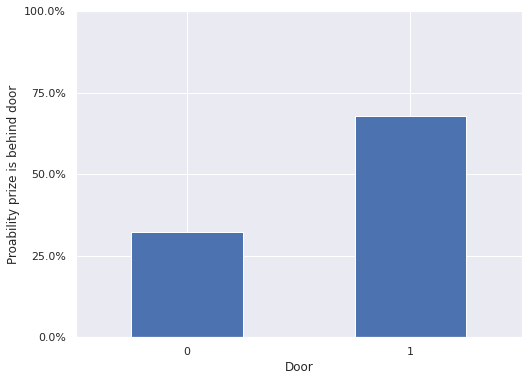

In [24]:
fig, ax = plt.subplots()

(monty_trace.posterior
            .to_dataframe()
            .value_counts(sort=False, normalize=True)
            .plot(kind='bar', ax=ax));

ax.set_xticklabels([0, 1], rotation=0);
ax.set_xlabel("Door");

ax.yaxis.set_major_formatter(pct_formatter);
ax.set_yticks(np.linspace(0, 1, 5));
ax.set_ylabel("Proability prize is behind door");

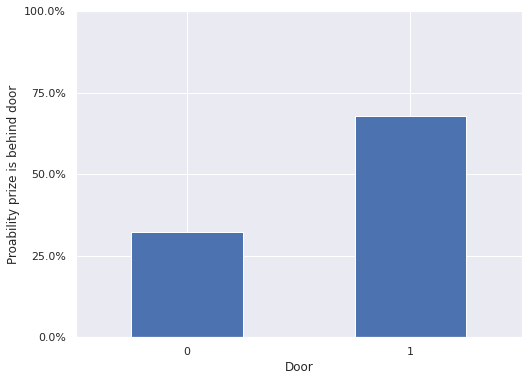

In [25]:
fig

### Two key components

#### [PyMC distributions](https://docs.pymc.io/en/v3/api/distributions.html)

<center>
<table>
    <tr>
        <td>
            <img src="https://docs.pymc.io/en/v3/_images/continuous-18.png">
        </td>
        <td>
            <img src="https://docs.pymc.io/en/v3/api/distributions/discrete-13.png">
        </td>
        <td>
            <img src="https://media.giphy.com/media/xUA7b0Klw8Wfor7FWo/giphy.gif">
        </td>
    </tr>
    <tr>
        <td>
            <center><a href="https://docs.pymc.io/en/v3/api/distributions/continuous.html#pymc3.distributions.continuous.Normal">Normal distribution</a></center>
        </td>
        <td>
            <center><a href="https://docs.pymc.io/en/v3/api/distributions/discrete.html#pymc3.distributions.discrete.ZeroInflatedPoisson">Zero-inflated Poisson</a></center>
        </td>
        <td><center>Distributions are the building bricks of our statistical models</center></td>
    </tr>
</table>
</center>

<center>
<figure>
    <img src="https://raw.githubusercontent.com/aesara-devs/aesara/main/doc/images/aesara_logo_2400.png" width=400>
    <caption>
        <a href="https://github.com/aesara-devs/aesara">GitHub</a> | <a href="https://aesara.readthedocs.io/en/latest/">Documentation</a>
    </caption>
</figure>
</center>

> Aesara is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. Aesara features:
>
> * Tight integration with NumPy – Use numpy.ndarray in Aesara-compiled functions.
> * **Efficient symbolic differentiation – Aesara does your derivatives for functions with one or many inputs.**
> * Speed and stability optimizations – Get the right answer for log(1+x) even when x is really tiny.
> * Dynamic C/JAX/Numba code generation – Evaluate expressions faster.
> 
> Aesara is based on Theano, which has been powering large-scale computationally intensive scientific investigations since 2007.

### Robust Regression

#### [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

This code for plotting Anscombe's quartet is adapted from the [`matplotlib` documentation](https://matplotlib.org/stable/gallery/specialty_plots/anscombe.html).

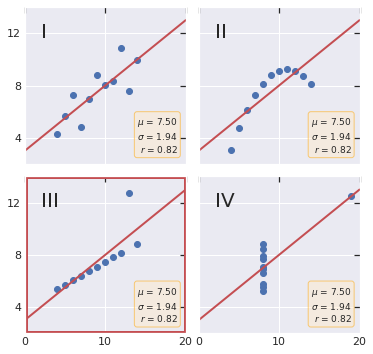

In [26]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5], dtype=np.float64)
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6),
                        gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
axs[0, 0].set(xlim=(0, 20), ylim=(2, 14))
axs[0, 0].set(xticks=(0, 10, 20), yticks=(4, 8, 12))

for ax, (label, (x_, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x_, y, 'o')

    # linear regression
    p1, p0 = np.polyfit(x_, y, deg=1)  # slope, intercept
    ax.axline(xy1=(0, p0), slope=p1, color='r', lw=2)

    # add text box for the statistics
    stats = (f'$\\mu$ = {np.mean(y):.2f}\n'
             f'$\\sigma$ = {np.std(y):.2f}\n'
             f'$r$ = {np.corrcoef(x_, y)[0][1]:.2f}')
    bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
    ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='right')
    
axs[1, 0].add_artist(plt.Rectangle((0, 2), 20, 12, fill=False, edgecolor='r', lw=5));

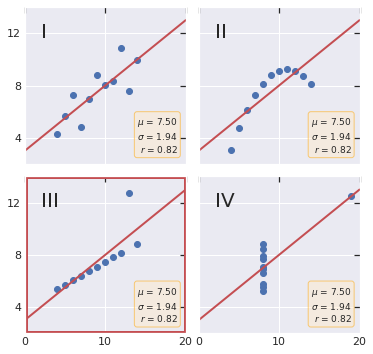

In [27]:
fig

#### Ordinary least squares

**Assumption:** All values of $m, b \in \mathbb{R}$, $\sigma > 0$ are equally likely

In [28]:
with pm.Model() as ols_model:
    m = pm.Flat("m")
    b = pm.Flat("b")

    σ = pm.HalfFlat("σ")

$$y\ |\ x = m x + b + \varepsilon,\ \varepsilon \sim N(0, \sigma^2)$$

This is equivalent to

$$y\ |\ x \sim N(m x + b, \sigma^2)$$

In [29]:
with ols_model:
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)

In [30]:
with ols_model:
    ols_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [31]:
import arviz as az

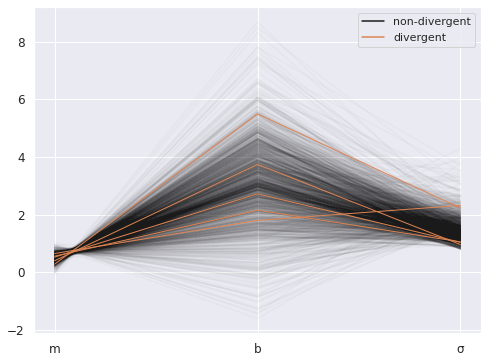

In [32]:
az.plot_parallel(ols_trace);

### Two more key components

<center>
<figure>
    <img src="https://arviz-devs.github.io/arviz/_static/logo.png" width=400>
    <caption>
        <a href="https://github.com/arviz-devs/arviz">GitHub</a> | <a href="https://arviz-devs.github.io/arviz/">Documentation</a>
    </caption>
</figure>
</center>

> ArviZ is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, data storage, sample diagnostics, model checking, and comparison.
>
> The goal is to provide backend-agnostic tools for diagnostics and visualizations of Bayesian inference in Python, by first converting inference data into xarray objects. See here for more on **xarray** and ArviZ usage and here for more on InferenceData structure and specification.

In [33]:
type(ols_trace)

arviz.data.inference_data.InferenceData

In [34]:
type(ols_trace.posterior)

xarray.core.dataset.Dataset

<center>
<figure>
    <img src="https://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" width=400>
    <caption>
        <a href="https://github.com/pydata/xarray">GitHub</a> | <a href="https://xarray.pydata.org/en/stable/">Documentation</a>
    </caption>
</figure>
</center>

> xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!

> Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.

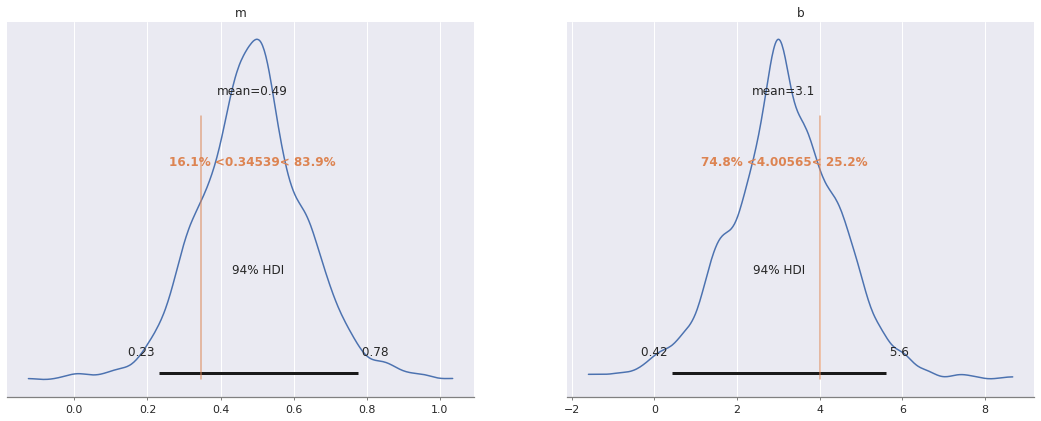

In [35]:
m_robust, b_robust = np.polyfit(x[x != 13], y3[x != 13], deg=1) 

az.plot_posterior(ols_trace, var_names=["m", "b"],
                  ref_val=[m_robust, b_robust]);

In [36]:
REG_THIN = 5

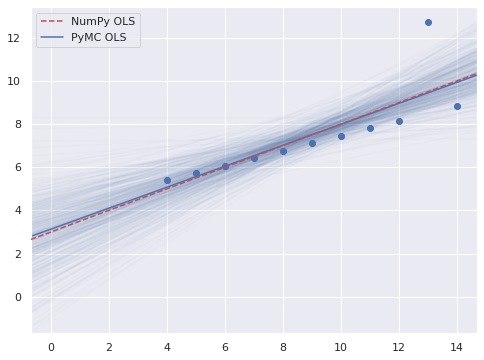

In [37]:
fig, ax = plt.subplots()

for m, b in zip(ols_trace.posterior["m"].values.flat[::REG_THIN],
                ols_trace.posterior["b"].values.flat[::REG_THIN]):
    ax.axline((0, b), slope=m, alpha=0.025, c='C0');

ax.scatter(x, y3);

ax.axline(xy1=(0, p0), slope=p1,
          color='r', ls='--', zorder=5,
          label="NumPy OLS");

ax.axline(
    (0, ols_trace.posterior["b"].mean()),
    slope=ols_trace.posterior["m"].mean(),
    c='C0', label="PyMC OLS"
);

ax.legend();

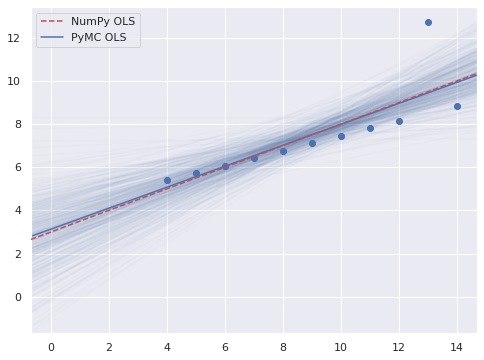

In [38]:
fig

#### Ridge regression

Ridge regression is equivalent to normal priors on $m$ and $b$.

$$
\begin{align*}
    m, b
        & \sim N(0, 1) \\
    \sigma
        & \sim \text{Half}-N(1) \\
    y\ |\ x
        & \sim N(m x + b, \sigma^2)
\end{align*}
$$

In [39]:
with pm.Model() as ridge_model:
    m = pm.Normal("m", 0., 1)
    b = pm.Normal("b", 0., 1)

    σ = pm.HalfNormal("σ", 1)
    y_obs = pm.Normal("y_obs", m * x + b, σ, observed=y3)
    
    ridge_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


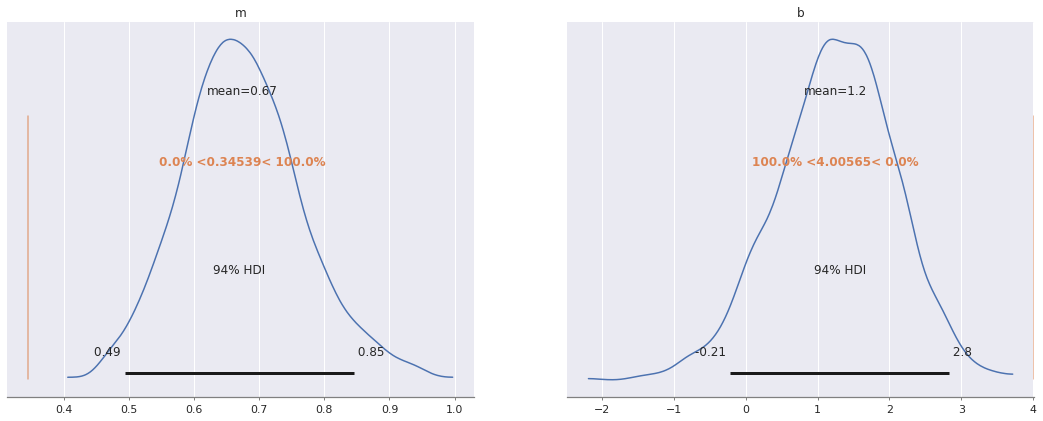

In [40]:
az.plot_posterior(ridge_trace, var_names=["m", "b"],
                  ref_val=[m_robust, b_robust]);

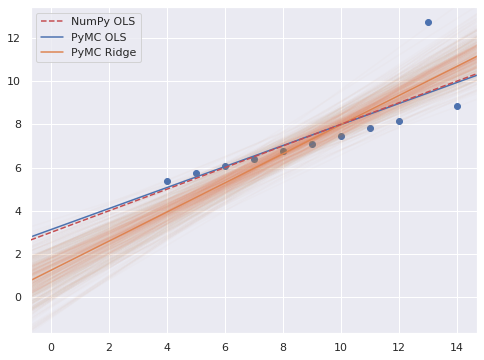

In [41]:
fig, ax = plt.subplots()

for m, b in zip(ridge_trace.posterior["m"].values.flat[::REG_THIN],
                ridge_trace.posterior["b"].values.flat[::REG_THIN]):
    ax.axline((0, b), slope=m, alpha=0.025, c='C1');

ax.scatter(x, y3);

ax.axline(xy1=(0, p0), slope=p1,
          color='r', ls='--', zorder=5,
          label="NumPy OLS");

ax.axline(
    (0, ols_trace.posterior["b"].mean()),
    slope=ols_trace.posterior["m"].mean(),
    c='C0', label="PyMC OLS"
);
ax.axline(
    (0, ridge_trace.posterior["b"].mean()),
    slope=ridge_trace.posterior["m"].mean(),
    c='C1', label="PyMC Ridge"
);


ax.legend();

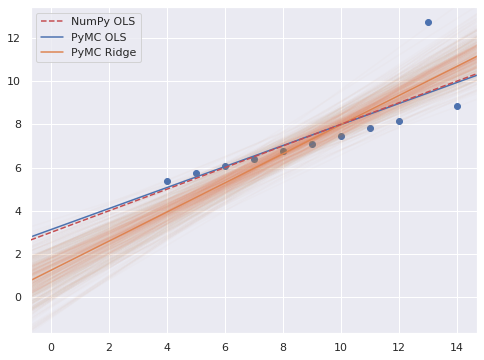

In [42]:
fig

#### Robust regression

[Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) has fatter tails than the normal distribution.

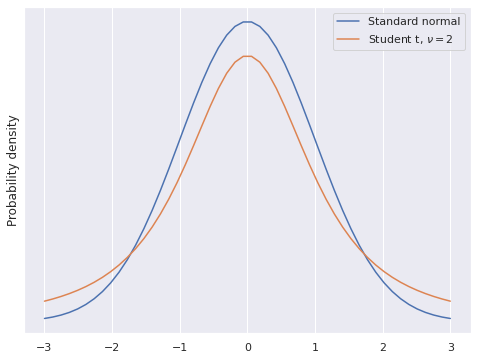

In [43]:
fig, ax = plt.subplots()

x_plot = np.linspace(-3, 3)
ax.plot(x_plot, sp.stats.norm.pdf(x_plot),
        label="Standard normal");

DF = 2
ax.plot(x_plot, sp.stats.t.pdf(x_plot, DF),
        label=f"Student t, $\\nu = {DF}$");

ax.set_yticks([]);
ax.set_ylabel("Probability density");

ax.legend();

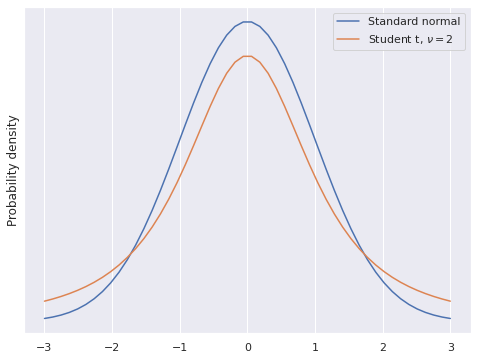

In [44]:
fig

In [45]:
with pm.Model() as robust_model:
    m = pm.Normal("m", 0., 1)
    b = pm.Normal("b", 0., 1)
    
    σ = pm.HalfNormal("σ", 1)

A Student t-likelihood is less sensitive to outliers

$$
\begin{align*}
    \nu
        & \sim U(1, 10) \\
    y\ |\ x
        & \sim \mathcal{T}_{\nu}(m x + b, \sigma^2)
\end{align*}
$$

In [46]:
with robust_model:
    ν = pm.Uniform("ν", 1, 10, initval=3)    
    y_obs = pm.StudentT(
        "y_obs",
        nu=ν, mu=m * x + b, sigma=σ,
        observed=y3
    )
    
    robust_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b, σ, ν]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.6695, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


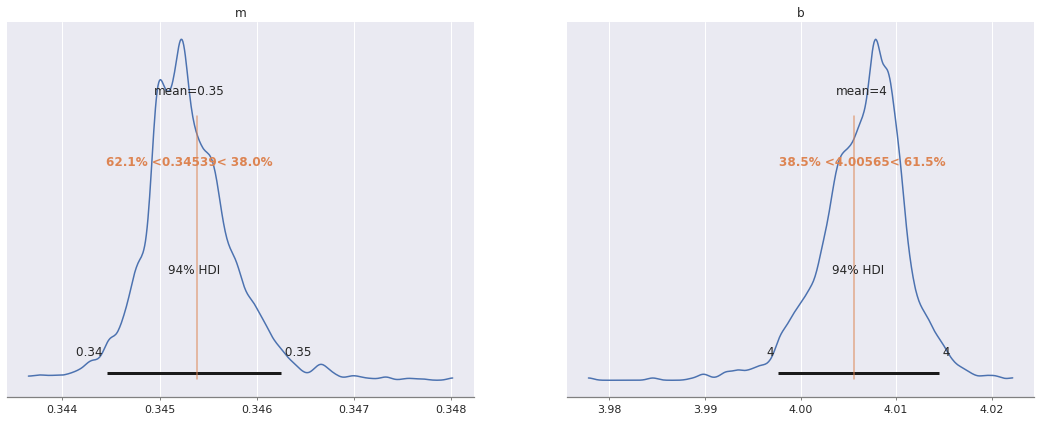

In [47]:
az.plot_posterior(robust_trace, var_names=["m", "b"],
                  ref_val=[m_robust, b_robust]);

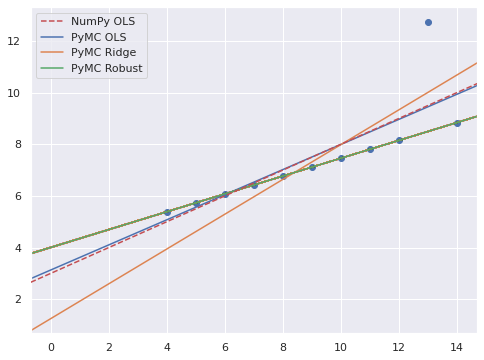

In [48]:
fig, ax = plt.subplots()

for m, b in zip(robust_trace.posterior["m"].values.flat[::REG_THIN],
                robust_trace.posterior["b"].values.flat[::REG_THIN]):
    ax.axline((0, b), slope=m, alpha=0.025, c='C1');

ax.scatter(x, y3);

ax.axline(xy1=(0, p0), slope=p1,
          color='r', ls='--', zorder=5,
          label="NumPy OLS");

ax.axline(
    (0, ols_trace.posterior["b"].mean()),
    slope=ols_trace.posterior["m"].mean(),
    c='C0', label="PyMC OLS"
);
ax.axline(
    (0, ridge_trace.posterior["b"].mean()),
    slope=ridge_trace.posterior["m"].mean(),
    c='C1', label="PyMC Ridge"
);
ax.axline(
    (0, robust_trace.posterior["b"].mean()),
    slope=robust_trace.posterior["m"].mean(),
    c='C2', label="PyMC Robust"
);



ax.legend();

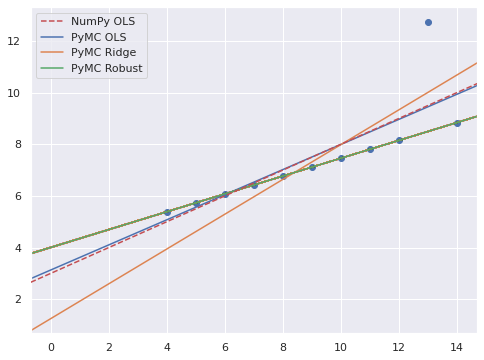

In [49]:
fig

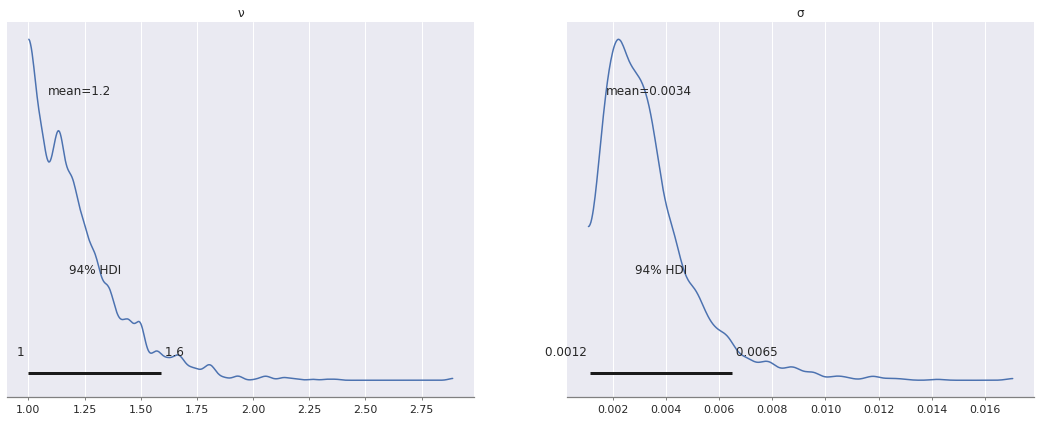

In [50]:
az.plot_posterior(robust_trace, var_names=["ν", "σ"]);

## Hamiltonian Monte Carlo

### Bayesian inference ⇔ Differential geometry

<center>
<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/61/Gaussian_curvature.svg">
    <caption>Image credit: <a href="https://commons.wikimedia.org/wiki/File:Gaussian_curvature.svg">Wikipedia</a></caption>
</figure>
</center>

#### The Curse of Dimensionality

In [51]:
def sphere_volume(d):
    return 2. * np.power(np.pi, d / 2.) / d / sp.special.gamma(d / 2)

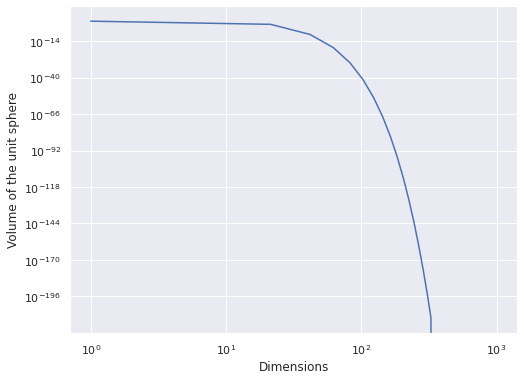

In [52]:
fig, ax = plt.subplots()

d_plot = np.linspace(1, 1_000)

ax.plot(d_plot, sphere_volume(d_plot));

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_yscale('log');
ax.set_ylabel("Volume of the unit sphere");

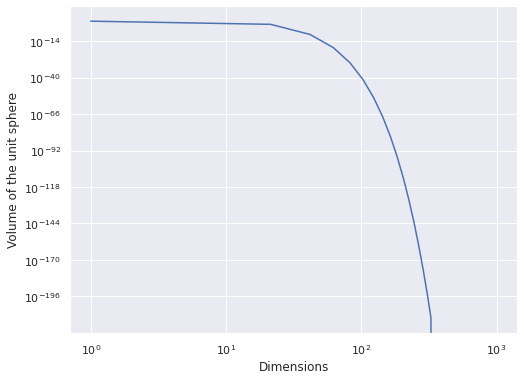

In [53]:
fig

### Automating calculus with `aesara`

$$\frac{d}{dx} \left(x^3\right) = 3 x^2$$

In [54]:
x = aet.scalar("x")

y = x**3

In [55]:
pprint(aet.grad(y, x))

'((fill((x ** 3), 1.0) * 3) * (x ** (3 - 1)))'

## A Bayesian Analysis of Lego Prices

<center>
<table>
    <tr>
        <td><img src="https://austinrochford.com/resources/lego/IMG_5698.png"></td>
        <td><img src="https://austinrochford.com/resources/lego/IMG_5696.png"></td>
        <td><img src="https://www.lego.com/cdn/cs/set/assets/blt234378cdb80fb126/75296.jpg" width=400></td>
    </tr>
    <tr>
        <td colspan=2></td>
        <td><center>Is this worth $69.99?</center></td>
    </tr>
</table>
</center>

### Scraped from [Brickset](https://brickset.com/)

<center><img src="https://images.brickset.com/news/Brickset%20Logo.png"></center>

In [56]:
LEGO_DATA_URL = "https://austinrochford.com/resources/talks/data_umbrella_brickset_19800101_20211098.csv"

In [57]:
lego_df = pd.read_csv(LEGO_DATA_URL,
                      parse_dates=["Year released"],
                      index_col="Set number")
lego_df["Year released"] = lego_df["Year released"].dt.year

In [58]:
lego_df.head()

,Name,Set type,Theme,Year released,Pieces,Subtheme,RRP$,RRP2021
Set number,,,,,,,,
1041-2,Educational Duplo Building Set,Normal,Dacta,1980,68.0,NaN,36.50,122.721632
1075-1,LEGO People Supplementary Set,Normal,Dacta,1980,304.0,NaN,14.50,48.752429
5233-1,Bedroom,Normal,Homemaker,1980,26.0,NaN,4.50,15.130064
6305-1,Trees and Flowers,Normal,Town,1980,12.0,Accessories,3.75,12.608387
6306-1,Road Signs,Normal,Town,1980,12.0,Accessories,2.50,8.405591


In [59]:
lego_df.tail()

,Name,Set type,Theme,Year released,Pieces,Subtheme,RRP$,RRP2021
Set number,,,,,,,,
80025-1,Sandy's Power Loader Mech,Normal,Monkie Kid,2021,520.0,Season 2,54.99,54.99
80026-1,Pigsy's Noodle Tank,Normal,Monkie Kid,2021,662.0,Season 2,59.99,59.99
80028-1,The Bone Demon,Normal,Monkie Kid,2021,1375.0,Season 2,119.99,119.99
80106-1,Story of Nian,Normal,Seasonal,2021,1067.0,Chinese Traditional Festivals,79.99,79.99
80107-1,Spring Lantern Festival,Normal,Seasonal,2021,1793.0,Chinese Traditional Festivals,119.99,119.99


In [60]:
lego_df.describe()

,Year released,Pieces,RRP$,RRP2021
count,6423.000000,6423.000000,6423.000000,6423.000000
mean,2009.719913,345.121283,37.652064,46.267159
std,8.940608,556.907975,50.917343,59.812083
min,1980.000000,11.000000,0.600000,0.971220
25%,2003.000000,69.000000,9.990000,11.896044
50%,2012.000000,181.000000,19.990000,27.420158
75%,2017.000000,404.000000,49.990000,56.497192
max,2021.000000,11695.000000,799.990000,897.373477


In [61]:
VADER_MEDITATION = "75296-1"

vader_label = f"{lego_df.loc[VADER_MEDITATION, 'Name']} ({VADER_MEDITATION.split('-')[0]})"

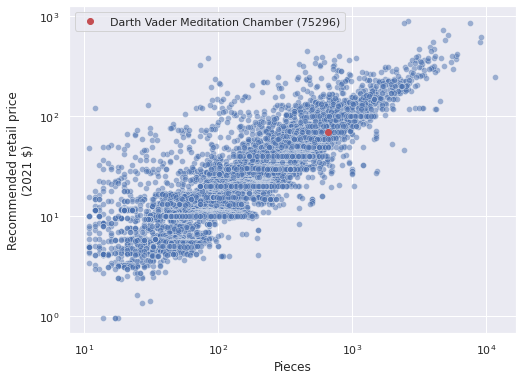

In [62]:
ax = sns.scatterplot(x="Pieces", y="RRP2021", data=lego_df,
                     alpha=0.5)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Pieces"],
           lego_df.loc[VADER_MEDITATION, "RRP2021"],
           c='r', label=vader_label);

ax.set_xscale('log');

ax.set_yscale('log');
ax.set_ylabel("Recommended retail price\n(2021 $)");

ax.legend();

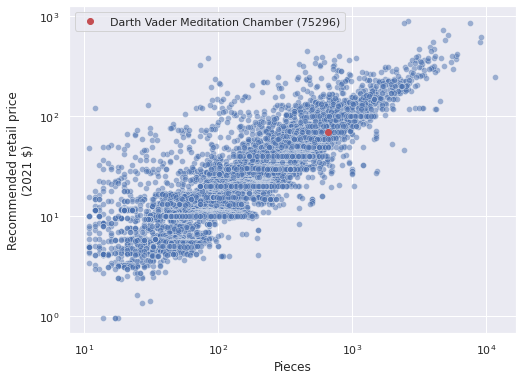

In [63]:
ax.figure

In [64]:
lego_df["PPP2021"] = lego_df["RRP2021"] / lego_df["Pieces"]

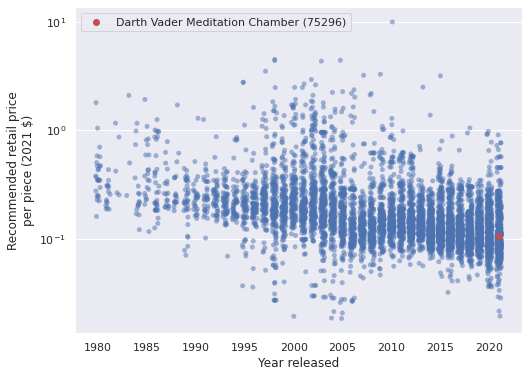

In [65]:
ax = sns.stripplot(x="Year released", y="PPP2021", data=lego_df,
                   jitter=0.25, color='C0', alpha=0.5)
ax.scatter(lego_df.loc[VADER_MEDITATION, "Year released"] - lego_df["Year released"].min(),
           lego_df.loc[VADER_MEDITATION, "PPP2021"],
           c='r', zorder=10, label=vader_label);

ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

ax.set_yscale('log');
ax.set_ylabel("Recommended retail price\nper piece (2021 $)");

ax.legend();

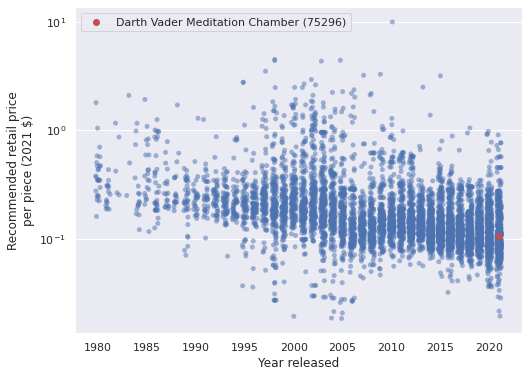

In [66]:
ax.figure

In [67]:
PLOT_THEMES = ["Star Wars", "Creator", "Disney", "Harry Potter"]

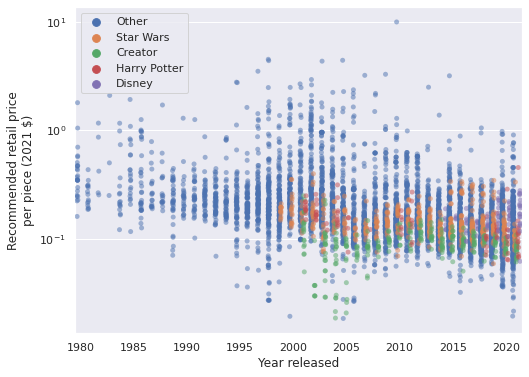

In [68]:
ax = sns.stripplot(
    x="Year released", y="PPP2021", hue="Theme",
    data=lego_df.assign(
       Theme=lego_df["Theme"]
                    .where(lego_df["Theme"].isin(PLOT_THEMES),
                           "Other")
   ),
   jitter=0.25, dodge=True, alpha=0.5
)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

ax.set_yscale('log');
ax.set_ylabel("Recommended retail price\nper piece (2021 $)");

ax.legend(loc='upper left');

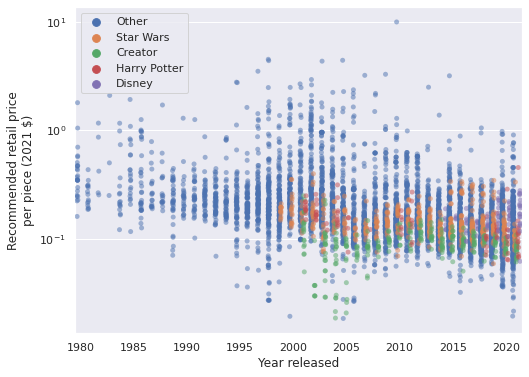

In [69]:
ax.figure

### Price model

$$\log \text{Price} \approx (\text{Year intercept}) + (\text{Theme intercept}) + \left((\text{Year slope}) + (\text{Theme slope})\right) \cdot \log \text{Pieces}$$

In [70]:
log_pieces = (lego_df["Pieces"]
                     .pipe(np.log)
                     .values)

scaler = StandardScaler().fit(log_pieces[:, np.newaxis])

def scale_log_pieces(log_pieces, scaler=scaler):
    return scaler.transform(log_pieces[:, np.newaxis])[:, 0]

std_log_pieces = scale_log_pieces(log_pieces)

In [71]:
log_rrp2021 = (lego_df["RRP2021"]
                      .pipe(np.log)
                      .values)

In [72]:
theme_id, theme_map = lego_df["Theme"].factorize(sort=True)

In [73]:
year = lego_df["Year released"].values
t = year - year.min()

In [74]:
def noncentered_normal(name, *, dims, μ=None):
    μ = pm.Normal(f"μ_{name}", 0., 2.5)
    Δ = pm.Normal(f"Δ_{name}", 0., 1., dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5)
    
    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

def gaussian_random_walk(name, *, dims, innov_scale=1.):
    Δ = pm.Normal(f"Δ_{name}", 0., innov_scale,  dims=dims)

    return pm.Deterministic(name, Δ.cumsum(), dims=dims)

In [75]:
coords = {
    "set": lego_df.index,
    "theme": theme_map,
    "year": np.unique(year)
}

In [76]:
with pm.Model(coords=coords) as lego_model:
    β0_t = gaussian_random_walk("β0_t", dims="year", innov_scale=0.1)
    β0_theme = noncentered_normal("β0_theme", dims="theme")
    
    β_piece_t = gaussian_random_walk("β_piece_t", dims="year", innov_scale=0.1)
    β_piece_theme = noncentered_normal("β_piece_theme", dims="theme")
    
    σ = pm.HalfNormal("σ", 5.)
    μ = β0_t[t] + β0_theme[theme_id] \
        + (β_piece_t[t] + β_piece_theme[theme_id]) * std_log_pieces \
        - 0.5 * σ**2
    
    obs = pm.Normal("obs", μ, σ, dims="set", observed=log_rrp2021)

#### Why _Hamiltonian_ Monte Carlo?

In [77]:
CHAINS = 3

SAMPLE_KWARGS = {
    'cores': CHAINS,
    'random_seed': [SEED + i for i in range(CHAINS)]
}

In [78]:
with lego_model:
    mh_lego_trace = pm.sample(draws=10_000, step=pm.Metropolis(),
                              **SAMPLE_KWARGS)

Multiprocess sampling (3 chains in 3 jobs)


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [79]:
mh_lego_rhat = az.rhat(mh_lego_trace)

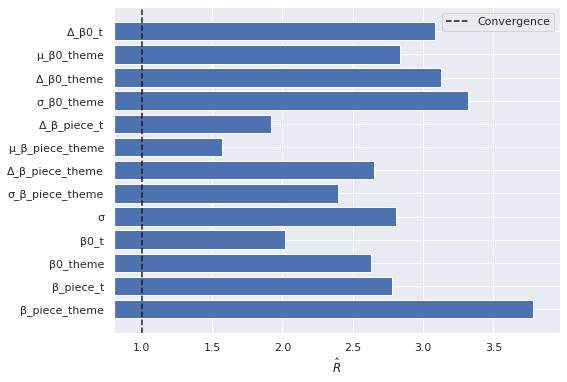

In [80]:
fig, ax = plt.subplots()

max_rhat = (mh_lego_rhat.max()
                        .to_array())
nvar, = max_rhat.shape

ax.barh(np.arange(nvar), max_rhat);
ax.axvline(1, c='k', ls='--', label="Convergence");

ax.set_xlim(left=0.8);
ax.set_xlabel(r"$\hat{R}$");

ax.set_yticks(np.arange(nvar));
ax.set_yticklabels(max_rhat.coords["variable"].to_numpy()[::-1]);

ax.legend();

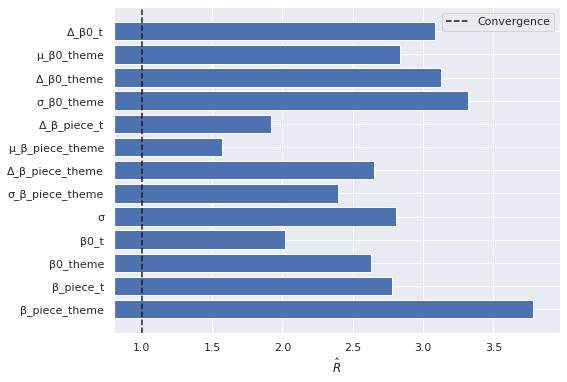

In [81]:
fig

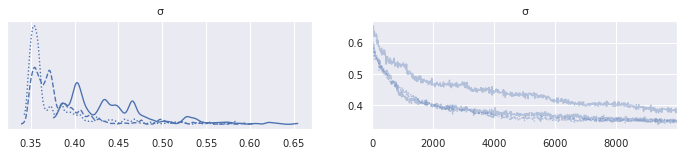

In [82]:
az.plot_trace(mh_lego_trace, var_names="σ");

This model has

In [83]:
n_lego_param = sum([
    coords["year"].size,  # time intercept increments
    coords["theme"].size, # theme intercept offsets
    2,                    # theme intercept location and scale
    coords["year"].size,  # time slope increments
    coords["theme"].size, # theme slope offsets
    2,                    # theme intercept location and scale
    1                     # scale of observational noise
])

In [84]:
n_lego_param

351

parameters

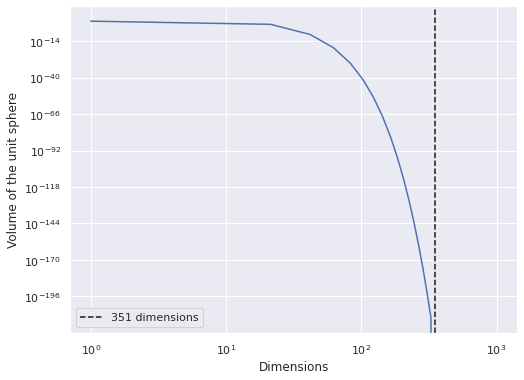

In [85]:
fig, ax = plt.subplots()

d_plot = np.linspace(1, 1_000)

ax.plot(d_plot, sphere_volume(d_plot));
ax.axvline(n_lego_param, c='k', ls='--', label=f"{n_lego_param} dimensions");

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_yscale('log');
ax.set_ylabel("Volume of the unit sphere");

ax.legend();

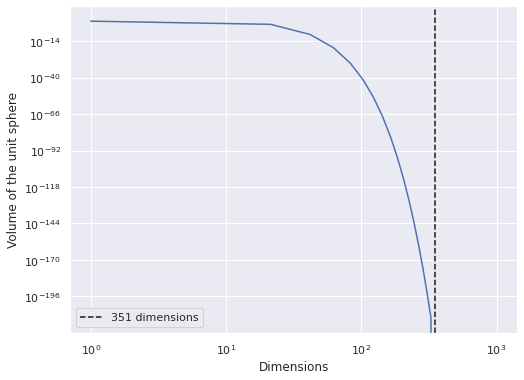

In [86]:
fig

In [87]:
with lego_model:
    lego_trace = pm.sample(**SAMPLE_KWARGS)
    lego_trace.extend(pm.sample_posterior_predictive(lego_trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Δ_β0_t, μ_β0_theme, Δ_β0_theme, σ_β0_theme, Δ_β_piece_t, μ_β_piece_theme, Δ_β_piece_theme, σ_β_piece_theme, σ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 579 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [88]:
lego_rhat = az.rhat(lego_trace).max()

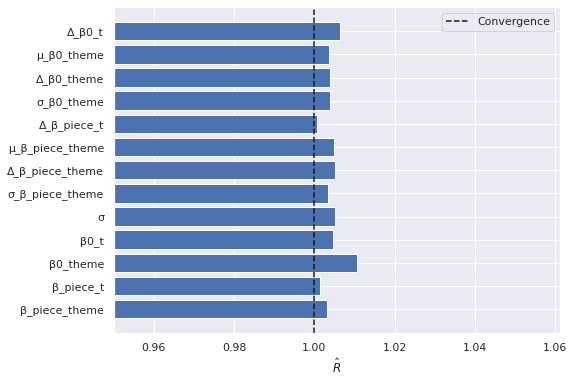

In [89]:
fig, ax = plt.subplots()

max_rhat = (lego_rhat.max()
                     .to_array())
nvar, = max_rhat.shape

ax.barh(np.arange(nvar), max_rhat);
ax.axvline(1, c='k', ls='--', label="Convergence");

ax.set_xlim(left=0.95);
ax.set_xlabel(r"$\hat{R}$");

ax.set_yticks(np.arange(nvar));
ax.set_yticklabels(max_rhat.coords["variable"].to_numpy()[::-1]);

ax.legend();

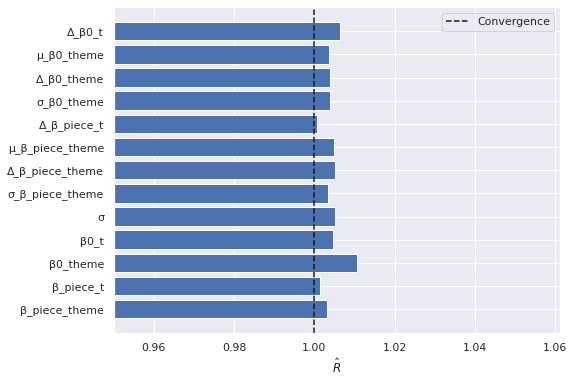

In [90]:
fig

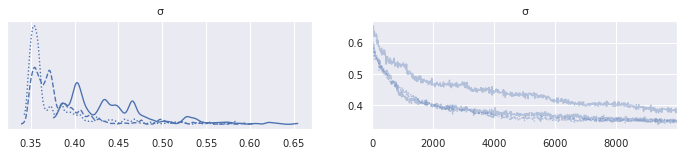

In [91]:
az.plot_trace(mh_lego_trace, var_names="σ");

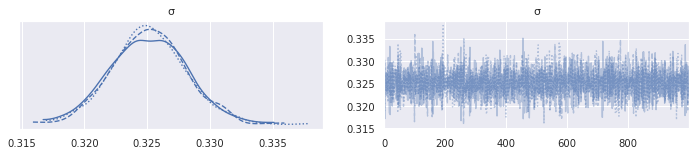

In [92]:
az.plot_trace(lego_trace, var_names="σ");

In [93]:
sampling_time = np.array([
    mh_lego_trace.sample_stats.sampling_time,
    lego_trace.sample_stats.sampling_time
])

σ_ess = np.array([
    az.ess(mh_lego_trace, var_names="σ")["σ"],
    az.ess(lego_trace, var_names="σ")["σ"]
])

σ_esps = σ_ess / sampling_time

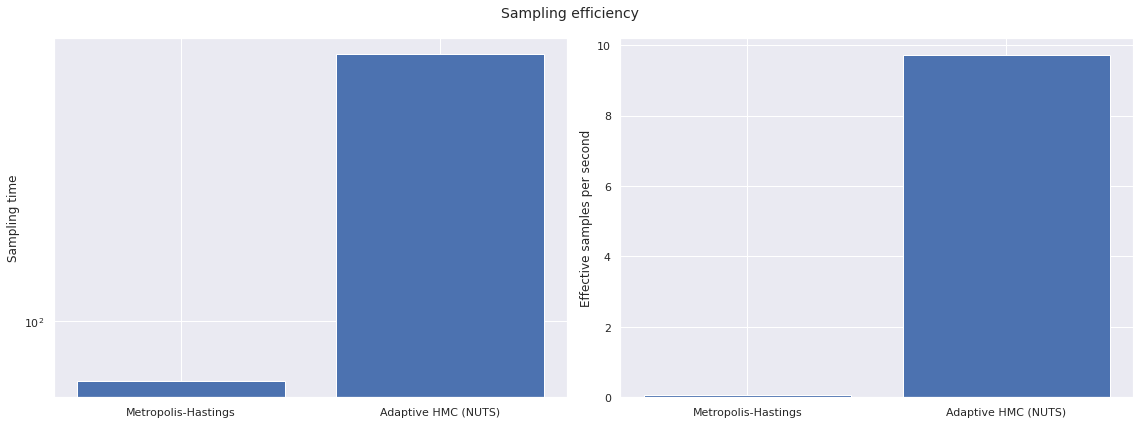

In [94]:
fig, axes = plt.subplots(ncols=2, sharex=True,
                         figsize=(2 * FIG_WIDTH, FIG_HEIGHT))

axes[0].bar([0, 1], sampling_time);

axes[0].set_xticks([0, 1]);
axes[0].set_xticklabels(["Metropolis-Hastings", "Adaptive HMC (NUTS)"]);

axes[0].set_yscale('log');
axes[0].set_ylabel("Sampling time");

axes[1].bar([0, 1], σ_esps);

axes[1].set_ylabel("Effective samples per second");

fig.suptitle("Sampling efficiency");
fig.tight_layout();

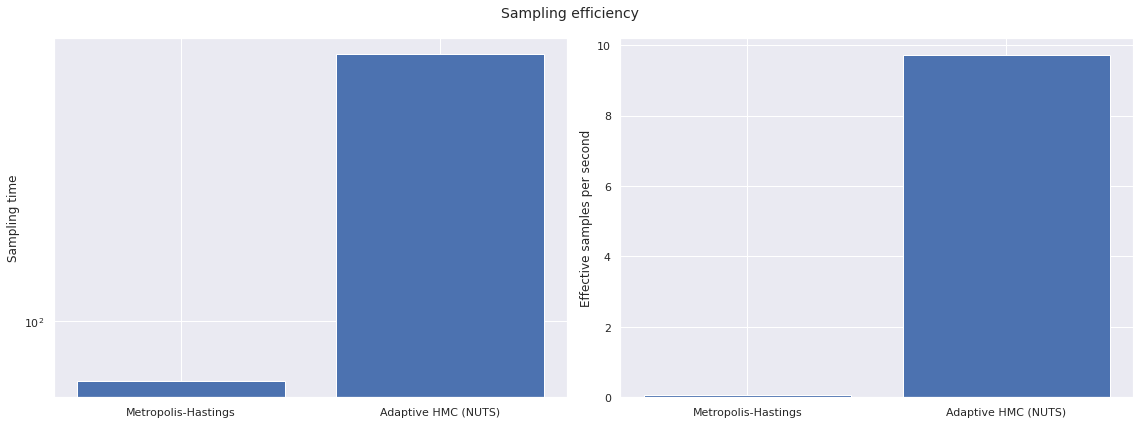

In [95]:
fig

To get the same effective sample size as adaptive HMC (NUTS) with Metropolis-Hastings would required approximately

In [96]:
σ_ess[1] / σ_esps[0] / 60 / 60

25.38753908221786

hours.

In [97]:
def format_posterior_artist(artist, formatter):
    text = artist.get_text()
    x, _ = artist.get_position()

    if text.startswith(" ") or text.endswith(" "):
        fmtd_text = formatter(x)
        artist.set_text(
            " " + fmtd_text if text.startswith(" ") else fmtd_text + " "
        )
    elif "=" in text:
        before, _ = text.split("=")
        artist.set_text("=".join((before, formatter(x))))
    elif "<" in text:
        below, ref_val_str, above = text.split("<")
        artist.set_text("<".join((
            below,
            " " + formatter(float(ref_val_str)) + " ",
            above
        )))

def format_posterior_text(formatter, ax=None):
    if ax is None:
        ax = plt.gca()
    
    artists = [artist for artist in ax.get_children() if isinstance(artist, plt.Text)]
    
    for artist in artists:
        format_posterior_artist(artist, formatter)

#### Is Darth Vader's Meditation Chamber priced fairly?

In [98]:
%%capture
ax = az.plot_posterior(
    lego_trace, group="posterior_predictive",
    coords={"set": VADER_MEDITATION},
    transform=np.exp, ref_val=lego_df.loc[VADER_MEDITATION, "RRP2021"]
)

In [99]:
format_posterior_text(dollar_formatter, ax=ax);

ax.set_xlabel("Posterior predicted RRP (2021 $)");
ax.set_title(vader_label);

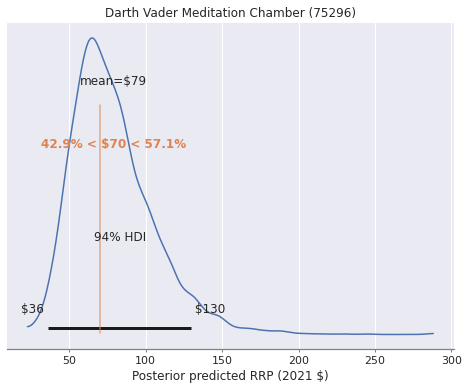

In [100]:
ax.figure

In [101]:
%%capture
ax, = az.plot_forest(
    lego_trace, var_names="β0_theme",
    coords={"theme": PLOT_THEMES}, combined=True,
    kind='ridgeplot', ridgeplot_alpha=0.5,
    ridgeplot_truncate=False, hdi_prob=1
)

ax.axvline(lego_trace.posterior["μ_β0_theme"]
                     .mean(dim=("chain", "draw")),
           c='k', ls='--', label="Average (all themes)");

In [102]:
ax.set_xticks([]);
ax.set_xlabel(r"$\beta_{0, \mathrm{theme}}$");

ax.set_yticklabels(PLOT_THEMES[::-1]);

ax.legend();

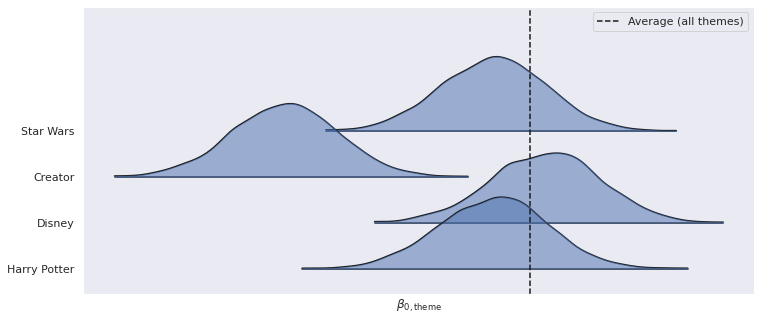

In [103]:
ax.figure

In [104]:
%%capture
ax, = az.plot_forest(
    lego_trace, var_names="β_piece_theme",
    coords={"theme": PLOT_THEMES}, combined=True,
    kind='ridgeplot', ridgeplot_alpha=0.5,
    ridgeplot_truncate=False, hdi_prob=1
)

ax.axvline(lego_trace.posterior["μ_β_piece_theme"]
                     .mean(dim=("chain", "draw")),
           c='k', ls='--', label="Average (all themes)");

In [105]:
ax.set_xticks([]);
ax.set_xlabel(r"$\beta_{\mathrm{piece}, \mathrm{theme}}$");

ax.set_yticklabels(PLOT_THEMES[::-1]);

ax.legend();

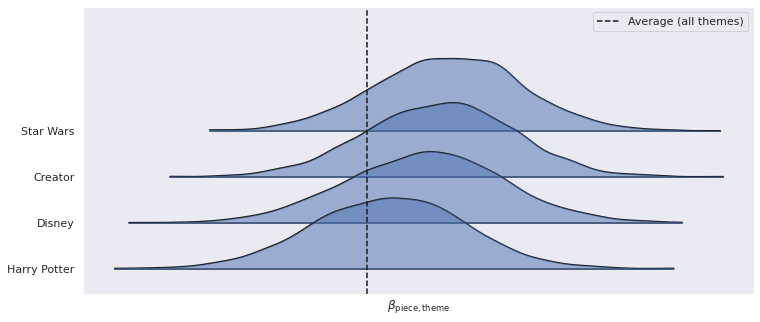

In [106]:
ax.figure

## Next steps

<center>
<table>
    <tr>
        <td><a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31"></a></td>
        <td><a href="https://github.com/pymc-devs/resources/tree/master/Rethinking"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg"></a></td>
        <td><a href="https://bayesiancomputationbook.com/welcome.html"><img src="https://images.routledge.com/common/jackets/amazon/978036789/9780367894368.jpg"></a></td>
    </tr>
</table>
</center>

## Thank you!

<center><img src="https://c.tenor.com/N1bwJbGUPNgAAAAC/thank-you-alice-in-wonderland.gif"></center>